In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

In [30]:
import pandas as pd
import re
import pickle
from tqdm import tqdm_notebook
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


import os
import tensorflow
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import pandas as pd
from termcolor import colored

C:\Users\koh swee guan\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\koh swee guan\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\koh swee guan\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\koh swee guan\Anaconda3\lib\site-packages\tensorflow\python\framework\dty

## Read data from sentiment 140

In [ ]:
sentiment = pd.read_csv("sentiment140.csv", encoding = "ISO-8859-1")
sentiment.columns=['polarity','tweetid','date','nq','author','tweet']
sentiment = sentiment.drop(["tweetid","date","nq","author"],axis=1)

### Understanding and Checking the dataset

In [ ]:
sentiment.head()

In [ ]:
sentiment.shape

In [ ]:
# Check for missing data
#traindata.isnull().values.any()
print("There is {} missing values in train data frame".format(sentiment.isnull().sum().sum()))

In [ ]:
# Check for duplicate test data
print("There is {} duplicated values in test data frame".format(sentiment.duplicated().sum()))

In [ ]:
duplicated = sentiment[sentiment.duplicated(keep=False)]
duplicated.head(4) # Show us just 2 duplications

In [ ]:
# Remove duplicates
sentiment.drop_duplicates(inplace=True)

# Confirm the removal
print("There is {} duplicated values in data frame".format(sentiment.duplicated().sum()))
sentiment.shape

In [ ]:
sentiment.polarity.value_counts().plot(kind="bar",subplots="True")
plt.show()

## Functions for cleaning the tweets

In [31]:
stop_words = set(stopwords.words('english'))
stop_words.remove("not")


def cleanText(s):
    bad_chars = [';', ':', '!', '*', '(' , ')', '&','[',']','.','?','{','}',',']
    non_ascii = "".join(i for i in s if ord(i)< 128)
    
    html_decoded_string = BeautifulSoup(non_ascii, "lxml")
    string = html_decoded_string.string
    
    non_name = " ".join((filter(lambda x:x[0]!='@', string.split())))
    non_badchars = ''.join(filter(lambda i: i not in bad_chars, non_name))
    non_links = re.sub(r"http\S+", "", non_badchars)
    non_websites = re.sub(r"www.[^ ]+","",non_links)
    non_numbers = re.sub(r"[0-9]+","",non_websites)
    
    clean = stopwords_stem(non_numbers)
    clean = decontracted(clean)
    
    return clean

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def stopwords_stem(document): 
    words = word_tokenize(document)
    words = removeStopwords(words)
    words = stemWords(words)
    result = ""
    for word in words:
        result += word + " "
    return result

def removeStopwords(document):
    result = []
    for word in document:
        if word not in stop_words:
            result.append(word)
    return result

def stemWords(document):
    """Stem words in list of tokenized words"""
    stemmer = PorterStemmer()
    result = []
    for word in document:
        stem = stemmer.stem(word)
        result.append(stem)
    return result



## Cleaning tweets from dataframe and transform to list
#### Can skip if load from disk (below)

In [ ]:
tweets = sentiment.tweet
print("Cleaning Tweets: ")
tweets = [cleanText(t) for t in tqdm_notebook(tweets)]
polarity = sentiment.polarity

### Save the processed tweets for later use

In [ ]:
with open('tweets.pickle', 'wb') as f:
    pickle.dump(tweets, f)
with open('polarity.pickle', 'wb') as f:
    pickle.dump(polarity, f)

### Load from saved files

In [ ]:
with open('tweets.pickle', 'rb') as f:
    tweets = pickle.load(f)
with open('polarity.pickle', 'rb') as f:
    polarity = pickle.load(f)

In [ ]:
for i in range(5):
    print(sentiment.tweet[i])
    print(tweets[i]+"\n")

# TrainTestSplitToCSV

In [ ]:
# Train test split
print(colored("Splitting train and test dataset into 80:20", "yellow"))
X_train, X_test, y_train, y_test = train_test_split(tweets, polarity, test_size = 0.2, random_state = 123)
train_dataset = pd.DataFrame({
    'Tweet': X_train,
    'Sentiment': y_train
    })
print(colored("Train data distribution:", "yellow"))
print(train_dataset['Sentiment'].value_counts())
test_dataset = pd.DataFrame({
    'Tweet': X_test,
    'Sentiment': y_test
    })
print(colored("Test data distribution:", "yellow"))
print(test_dataset['Sentiment'].value_counts())
print(colored("Split complete", "yellow"))

# Save train data
print(colored("Saving train data", "yellow"))

train_dataset.to_csv('train.csv', index = False)
print(colored("Train data saved to TrainTestSplitCSV/train.csv", "green"))

# Save test data
print(colored("Saving test data", "yellow"))
test_dataset.to_csv('test.csv', index = False)
print(colored("Test data saved to TrainTestSplitCSV/test.csv", "green"))

In [ ]:
# Train test split
print(colored("Splitting train and test dataset into 75:25", "yellow"))
X_train, X_test, y_train, y_test = train_test_split(tweets, polarity, test_size = 0.25, random_state = 123)
train_dataset = pd.DataFrame({
    'Tweet': X_train,
    'Sentiment': y_train
    })
print(colored("Train data distribution:", "yellow"))
print(train_dataset['Sentiment'].value_counts())
test_dataset = pd.DataFrame({
    'Tweet': X_test,
    'Sentiment': y_test
    })
print(colored("Test data distribution:", "yellow"))
print(test_dataset['Sentiment'].value_counts())
print(colored("Split complete", "yellow"))

# Save train data
print(colored("Saving train data", "yellow"))

train_dataset.to_csv('train.csv', index = False)
print(colored("Train data saved to TrainTestSplitCSV/train.csv", "green"))

# Save test data
print(colored("Saving test data", "yellow"))
test_dataset.to_csv('test.csv', index = False)
print(colored("Test data saved to TrainTestSplitCSV/test.csv", "green"))

### TF-IDF Vectorizer (SG)

In [2]:
import pandas as pd
import re
import pickle
from tqdm import tqdm_notebook
train = pd.read_csv("train.csv", encoding = "ISO-8859-1")
print (train.shape)
train.head()

(1266952, 2)


,Tweet,Sentiment
0,say `` free eyeshadow '' make miss old class e...,0
1,with girl peter,4
2,email friend andrea boston hope email back u g...,0
3,thank niceapart work one girl gave pressi ever...,4
4,did manag sort anoth flight you crack,4


In [3]:
test = pd.read_csv("test.csv")
print (test.shape)
test.head()

(316738, 2)


,Tweet,Sentiment
0,I drop phoner bad dropnot good and I smartli d...,0
1,apa lagi kalo musiknya tranc n is rave parti ...,4
2,chase left hayley come gatlinburg,0
3,out dinner fun sun boy,4
4,star trek excel who care time travel stuff com...,4


In [4]:
#train.dtypes

In [ ]:
# Check for duplicate train data
#print("There is {} duplicated values in train data frame".format(train.duplicated().sum()))

In [ ]:
# Check for duplicate test data
#print("There is {} duplicated values in test data frame".format(test.duplicated().sum()))

In [ ]:
#duplicated = train[train.duplicated(keep=False)]
#duplicated.head(10) # Show us just 2 duplications

In [ ]:
# Check for missing data
#traindata.isnull().values.any()
#print("There is {} missing values in train data frame".format(train.isnull().sum().sum()))
#print("There is {} missing values in test data frame".format(test.isnull().sum().sum()))

In [5]:
# Remove null from train data
print (train.shape)
train = train.dropna()
#df = df.dropna(axis=0, subset=['Charge_Per_Line'])
print (train.shape)
print("There is {} missing values in train data frame".format(train.isnull().sum().sum()))

(1266952, 2)
(1262467, 2)
There is 0 missing values in train data frame


In [6]:
# Remove null from test data
print (test.shape)
test = test.dropna()
print (test.shape)
print("There is {} missing values in train data frame".format(train.isnull().sum().sum()))

(316738, 2)
(315689, 2)
There is 0 missing values in train data frame


In [7]:
x_train = train['Tweet']
y_train = train['Sentiment']
x_test = test["Tweet"]
y_test = test['Sentiment']

In [8]:
print (x_train.shape, x_test.shape)
print (y_train.shape, y_test.shape)

(1262467,) (315689,)
(1262467,) (315689,)


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
#vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.8, sublinear_tf = True, use_idf = True)
ngram = (1,2)
vectorizer = TfidfVectorizer(ngram_range = ngram)
#train_vector = tfidf_ngram_vectorizer.fit_transform(tweets)

train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)
#kagtest_vectors = vectorizer.transform(testdata['Comment'])

## Exploring with Different Classifcation Models (SG)
As a few models are done at the same time, this part of the program do take a while.

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import time
import csv

nb = MultinomialNB()
svm = SVC(kernel='linear')
# GridSearchCV Optimised 
#svm = SVC(kernel='rbf')
lr = LogisticRegression( class_weight="balanced", random_state=42, solver='liblinear', max_iter=10000, C = 1, penalty= 'l2')
# GridSearchCV Optimised 
#lr = LogisticRegression( class_weight="balanced", random_state=42, solver='liblinear', max_iter=10000, C = 0.25, penalty= 'l2')
dt = DecisionTreeClassifier(max_depth=8, min_samples_split=50, min_samples_leaf=50, random_state=13)
rf = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=100)
ada = AdaBoostClassifier(n_estimators=100)
mlp = MLPClassifier(hidden_layer_sizes=(150,100,50), activation='relu', solver='adam', max_iter=100)
et = ExtraTreesClassifier(n_estimators = 100)          
gb = GradientBoostingClassifier(n_estimators = 100)    
xgb = XGBClassifier(n_estimators= 2000, learning_rate=0.01)

# define models
#models = {"Naive Bayes" : nb,
#          "SVM" : svm,
#          "Logistic Regression" : lr,
#          "Decision Tree" : dt,
#          "Random Forest" : rf,
#          "KNeighborst" : knn,
#          "AdaBoost" : ada,
#          "Multi-Layer Perceptron" : mlp,
#          "Extra Trees" : et,
#          "Gradient Boosting" : gb,
#          "Extreme Gradient Boosting" : xgb}
models = {"Naive Bayes" : nb,
          "Logistic Regression" : lr,
          "Decision Tree" : dt}

# Open file to write result of various models 
csvFile = open("result.csv", 'w+', newline='')
writer = csv.writer(csvFile)
writer.writerow(('Model','Accuracy(train)','Accuracy(test)','Time'))

# iterate through all models

for key, value in models.items():   
    start_time = time.time()
    model = value

    # fit & predict training score
    model.fit(train_vectors, y_train)
    y_train_predict = model.predict(train_vectors)
    y_test_predict = model.predict(test_vectors)
    
    accuracy1 = round(accuracy_score(y_train, y_train_predict), 5)
    accuracy2 = round(accuracy_score(y_test, y_test_predict), 5)
#    accuracy3 = round(f1_score(y_test, y_test_predict), 5)
    print (key, 'testing accuracy', accuracy2)
    end_time = time.time()
    elapsed_time = round((end_time - start_time), 5)

    # Write result to file
    writer.writerow ((key, accuracy1, accuracy2, elapsed_time))

    # save the model to disk
    #filename = 'finalized_model.sav'
    filename = key + '_model.sav'
    pickle.dump(model, open(filename, 'wb'))
    
#    # Make predictions on test data
#    kag_y_test_predict = model.predict(kagtest_vectors)
    
#    # Prepare submission file   
#    testdata['Outcome'] = kag_y_test_predict
#    df_submit = testdata[['Id', 'Outcome']]
#    filename = key + '_10.csv'
#    df_submit.to_csv(filename, index=False, header=True)

### CLOSE CSV FILE
csvFile.close()

Naive Bayes testing accuracy 0.78625
Logistic Regression testing accuracy 0.80435
Decision Tree testing accuracy 0.61716


In [20]:
# Read result file from CSV
result = pd.read_csv("result.csv")

# sort by testing accuracy
result.sort_values(by=["Accuracy(test)"], axis=0 ,ascending=False, inplace=True)
result.set_index('Model')

# TF-IDF
#Logistic Regression	0.79415	0.78469	11.47858
#Naive Bayes        	0.77418	0.76226	0.47203
#Decision Tree      	0.61696	0.61683	21.06831

# TF-IDF (ngrams)
#ngram = (1,2)
#vectorizer = TfidfVectorizer(ngram_range = ngram)
Logistic Regression 	0.86243	0.80435	42.32039
Naive Bayes         	0.89943	0.78625	1.13861
Decision Tree       	0.61743	0.61716	64.05016

,Accuracy(train),Accuracy(test),Time
Model,,,
Logistic Regression,0.86243,0.80435,42.32039
Naive Bayes,0.89943,0.78625,1.13861
Decision Tree,0.61743,0.61716,64.05016


Graph showing the Testing Accuracy for the various models


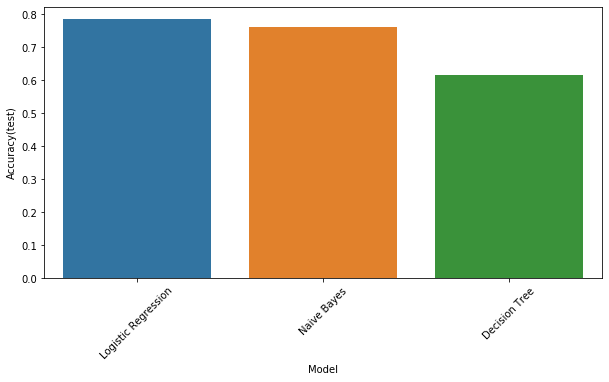

In [17]:
import seaborn as sns
#from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
# Plot testing accuracy for various models
plt.figure(figsize=(10,5))
sns.barplot(x=result['Model'],y=result["Accuracy(test)"])
plt.xticks(rotation=45) # Rotation of model names
print ('Graph showing the Testing Accuracy for the various models')

In [21]:
# Read result file from CSV
result = pd.read_csv("result.csv")

# sort by training accuracy
result.sort_values(by=["Accuracy(train)"], axis=0 ,ascending=False, inplace=True)
result.set_index('Model')

,Accuracy(train),Accuracy(test),Time
Model,,,
Naive Bayes,0.89943,0.78625,1.13861
Logistic Regression,0.86243,0.80435,42.32039
Decision Tree,0.61743,0.61716,64.05016


Graph showing the Training Accuracy for the various models


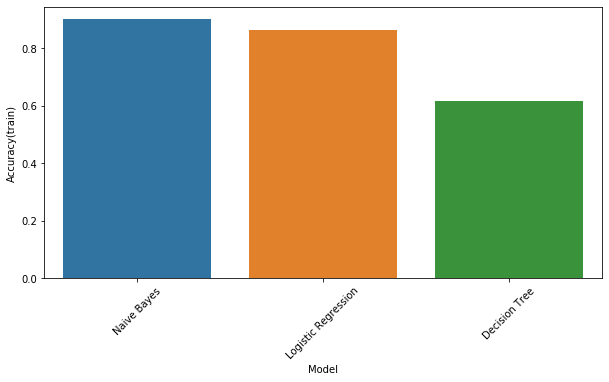

In [22]:
# Plot training accuracy for various models
plt.figure(figsize=(10,5))
sns.barplot(x=result['Model'],y=result["Accuracy(train)"])
plt.xticks(rotation=45) # Rotation of model names
print ('Graph showing the Training Accuracy for the various models')

In [23]:
# sort by timing
result.sort_values(by=["Time"], axis=0 ,ascending=True, inplace=True)
result.set_index('Model')

,Accuracy(train),Accuracy(test),Time
Model,,,
Naive Bayes,0.89943,0.78625,1.13861
Logistic Regression,0.86243,0.80435,42.32039
Decision Tree,0.61743,0.61716,64.05016


Graph showing the processing time for the various models


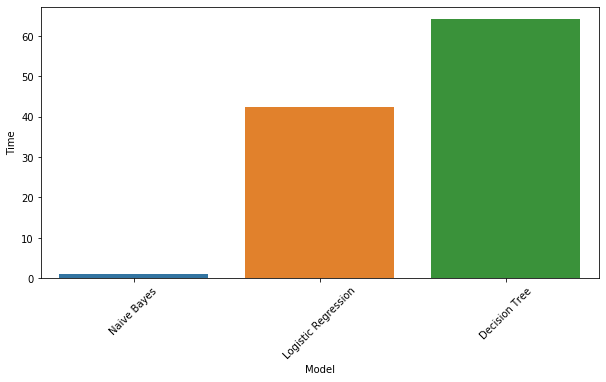

In [24]:
# Plot training time for various models
plt.figure(figsize=(10,5))
sns.barplot(x=result['Model'],y=result["Time"])
plt.xticks(rotation=45) # Rotation of model names

print ('Graph showing the processing time for the various models')

### The program shows that Algorithm xxx produces the best testing accuracy

In [ ]:
# Optimizing the Hyperparameters of Logistic Regression

In [ ]:
#Step 1 : determine the best kernel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
lg = LogisticRegression( class_weight="balanced", random_state=42, solver='liblinear', max_iter=10000, penalty = 'l2')
print(lg)
grid = {'solver':('liblinear', 'lbfgs', "sag", "saga"), 'C': [0.001, 0.01, 0.1, 1, 10]} # 
#grid = {'kernel':('liblinear', 'lbfgs', "sag", "saga"), "C" : np.arange(0.1,1,0.05)} # 
lg_cv = GridSearchCV(lg, grid, cv=5)
lg_cv.fit(x_train, y_train)

# 'C': [0.001, 0.01, 0.1, 1, 10]

# Print hyperparameter
print("Tuned hyperparameter parameters: {}".format(lg_cv.best_params_)) 
print("Best cross-validation score: {}".format(lg_cv.best_score_))
print("Best estimator: ", .format(lg_cv.best_estimator_))

In [ ]:
# Search for parameter
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
parameters = {'kernel':('liblinear', 'lbfgs', "sag", "saga"), 'C':[1, 10]}
svm = SVC()
clf = GridSearchCV(svm, parameters)
clf.fit(x_train,y_train)
#GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})
sorted(clf.cv_results_.keys())

# Classification of NTU, NUS & SMU Tweets

In [25]:
#Reading tweets from NTU, NUS & SMU
import pandas as pd
import re
import pickle
from tqdm import tqdm_notebook

In [26]:
ntu = pd.read_csv("ntu.csv")
nus = pd.read_csv("nus.csv")
smu = pd.read_csv("smu.csv")
ntu = ntu.drop(["tweet_id", "keyword","user"],axis=1)
nus = nus.drop(["tweet_id","keyword","user"],axis=1)
smu = smu.drop(["tweet_id","keyword","user"],axis=1)
ntu.head()

,Unnamed: 0,tweet,date_tweet
0,0,@IruraMwongera @Amen_Baba_ KOUMA (to be dry KM...,2020-02-09 07:36:08
1,1,You know how everyone’s introducing themselves...,2020-02-09 07:25:50
2,2,is ntu rly not gonna move big-group lectures o...,2020-02-09 07:07:53
3,3,"But also, the Chinese speaking groups that ope...",2020-02-09 06:19:15
4,4,@MigunaMiguna @DrMumbiSeraki When your faced w...,2020-02-09 05:54:39


In [35]:
from tqdm import tqdm_notebook
ntutweets = ntu.tweet
nustweets = nus.tweet
smutweets = smu.tweet
print("Cleaning Tweets: ")
ntutweets = [cleanText(t) for t in tqdm_notebook(ntutweets)]
nustweets = [cleanText(t) for t in tqdm_notebook(nustweets)]
smutweets = [cleanText(t) for t in tqdm_notebook(smutweets)]
ntudate = ntu.date_tweet
nusdate = nus.date_tweet
smudate = smu.date_tweet

Cleaning Tweets: 


C:\Users\koh swee guan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


C:\Users\koh swee guan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


C:\Users\koh swee guan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


### Save tweets for use later

In [39]:
#Save the processed tweets for later use
# save ntu tweets
with open('ntutweets.pickle', 'wb') as f:
    pickle.dump(ntutweets, f)
with open('ntudate.pickle', 'wb') as f:
    pickle.dump(ntudate, f)

# save nus tweets
with open('nustweets.pickle', 'wb') as f:
    pickle.dump(nustweets, f)
with open('nusdate.pickle', 'wb') as f:
    pickle.dump(nusdate, f)  

# save smu tweets
with open('smutweets.pickle', 'wb') as f:
    pickle.dump(smutweets, f)
with open('smudate.pickle', 'wb') as f:
    pickle.dump(smudate, f)    

### Load tweets

In [42]:
# Load ntu data
with open('ntutweets.pickle', 'rb') as f:
    ntutweets = pickle.load(f)
with open('ntudate.pickle', 'rb') as f:
    ntudate = pickle.load(f)
    
# Load nus data
with open('nustweets.pickle', 'rb') as f:
    nustweets = pickle.load(f)
with open('nusdate.pickle', 'rb') as f:
    nusdate = pickle.load(f)
    
# Load smu data
with open('smutweets.pickle', 'rb') as f:
    smutweets = pickle.load(f)
with open('smudate.pickle', 'rb') as f:
    smudate = pickle.load(f)

In [ ]:
### Saving tweets as dataframe

In [44]:
# Save as dataframe
ntu_data = pd.DataFrame({
    'Tweet': ntutweets,
    'Date': ntudate
    })

nus_data = pd.DataFrame({
    'Tweet': nustweets,
    'Date': nusdate
    })

smu_data = pd.DataFrame({
    'Tweet': smutweets,
    'Date': smudate
    })

# Save data
print(colored("Saving data", "blue"))
ntu_data.to_csv('ntu_data.csv', index = False)
nus_data.to_csv('nus_data.csv', index = False)
smu_data.to_csv('smu_data.csv', index = False)
ntu_data.head()

Saving data


,Tweet,Date
0,kouma dri KM kaa ukaa charcoal appear = black ...,2020-02-09 07:36:08
1,you know everyon introduc ntu student pursu ba...,2020-02-09 07:25:50
2,ntu rli not gon na move big-group lectur onlin,2020-02-09 07:07:53
3,but also chines speak group oper dialect would...,2020-02-09 06:19:15
4,when face forc mightier It advis humbl even ri...,2020-02-09 05:54:39


In [45]:
ntu_data = pd.read_csv("ntu_data.csv")
print (ntu_data.shape)
ntu_data.head()

nus_data = pd.read_csv("nus_data.csv")
print (nus_data.shape)
nus_data.head()

smu_data = pd.read_csv("smu_data.csv")
print (smu_data.shape)
smu_data.head()

(1198, 2)
(1397, 2)
(1500, 2)


,Tweet,Date
0,miss smu much,2020-02-14 07:52:14
1,happi valentin everyon special loml,2020-02-14 07:48:24
2,move friday # unt # uta # smu # utd # tcu,2020-02-14 07:30:03
3,now parad beauti smu # smucampusperson,2020-02-14 07:26:51
4,Go get r done sunday stud love watch smu,2020-02-14 07:15:30


In [46]:
# Remove null from ntu data
ntu_data = ntu_data.dropna()
#df = df.dropna(axis=0, subset=['Charge_Per_Line'])
print (ntu_data.shape)
print("There is {} missing values in ntu data frame".format(ntu_data.isnull().sum().sum()))

# Remove null from nus data
nus_datadata = nus_data.dropna()
#df = df.dropna(axis=0, subset=['Charge_Per_Line'])
print (nus_data.shape)
print("There is {} missing values in nus data frame".format(nus_data.isnull().sum().sum()))

# Remove null from smu data
smu_data = smu_data.dropna()
#df = df.dropna(axis=0, subset=['Charge_Per_Line'])
print (smu_data.shape)
print("There is {} missing values in smu data frame".format(ntu_data.isnull().sum().sum()))

(1198, 2)
There is 0 missing values in ntu data frame
(1397, 2)
There is 0 missing values in nus data frame
(1500, 2)
There is 0 missing values in smu data frame


In [47]:
train = pd.read_csv("train.csv", encoding = "ISO-8859-1")
test = pd.read_csv("test.csv", encoding = "ISO-8859-1")
train = train.dropna()
test = test.dropna()
x_train = train['Tweet']
y_train = train['Sentiment']
x_test = test["Tweet"]
y_test = test['Sentiment']

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
#vectorizer = TfidfVectorizer(min_df = 5,
#                             max_df = 0.8,
#                             sublinear_tf = True,
#                             use_idf = True)
ngram = (1,2)
vectorizer = TfidfVectorizer(ngram_range = ngram)
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)
ntu_vectors = vectorizer.transform(ntu_data['Tweet'])
nus_vectors = vectorizer.transform(nus_data['Tweet'])
smu_vectors = vectorizer.transform(smu_data['Tweet'])

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle
import time
import csv

# load the model from disk
loaded_model = pickle.load(open('Logistic Regression_model.sav', 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

# Make classification on tweets data
print ('Classifying NTU Tweets')
ntu_y_test_predict = loaded_model.predict(ntu_vectors)

print ('Classifying NUS Tweets')
nus_y_test_predict = loaded_model.predict(nus_vectors)

print ('Classifying SMU Tweets')
smu_y_test_predict = loaded_model.predict(smu_vectors)
    
# Prepare analysis file
# NTU
ntu_data['Sentiment'] = ntu_y_test_predict
ntu_submit = ntu_data[['Date', 'Sentiment']]
ntu_submit.to_csv('ntu_sent.csv', index=False, header=True)

# NUS
nus_data['Sentiment'] = nus_y_test_predict
nus_submit = nus_data[['Date', 'Sentiment']]
nus_submit.to_csv('nus_sent.csv', index=False, header=True)

# SMU
smu_data['Sentiment'] = smu_y_test_predict
smu_submit = smu_data[['Date', 'Sentiment']]
smu_submit.to_csv('smu_sent.csv', index=False, header=True)


Classifying NTU Tweets
Classifying NUS Tweets
Classifying SMU Tweets


### We can start understand the tweets from the classification

In [60]:
ntu_sent = pd.read_csv("ntu_sent.csv")
nus_sent = pd.read_csv("nus_sent.csv")
smu_sent = pd.read_csv("smu_sent.csv")
ntu_sent.head()
ntu_sent.describe()

,Sentiment
count,1198.000000
mean,2.964942
std,1.752556
min,0.000000
25%,0.000000
50%,4.000000
75%,4.000000
max,4.000000


NTU Tweets Sentiment
NTU Sentiment distribution:
4    888
0    310
Name: Sentiment, dtype: int64


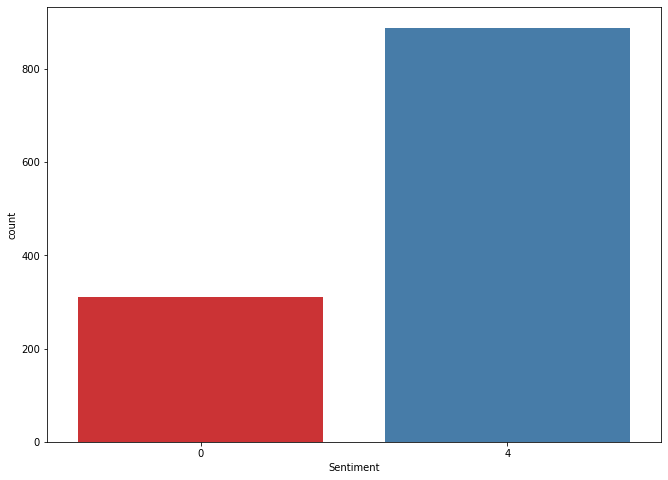

In [78]:
# checking dataset of NTU
import seaborn as sns
ntu_sent.groupby("Sentiment").count()
#traindata[["cardio","height"]].groupby("Outcome").count()
sns.countplot(x="Sentiment", data=ntu_sent, palette="Set1")
print ('NTU Tweets Sentiment')

print(colored("NTU Sentiment distribution:", "red"))
print(ntu_sent['Sentiment'].value_counts())


NUS Tweets Sentiment
NUS Sentiment distribution:
4    961
0    436
Name: Sentiment, dtype: int64


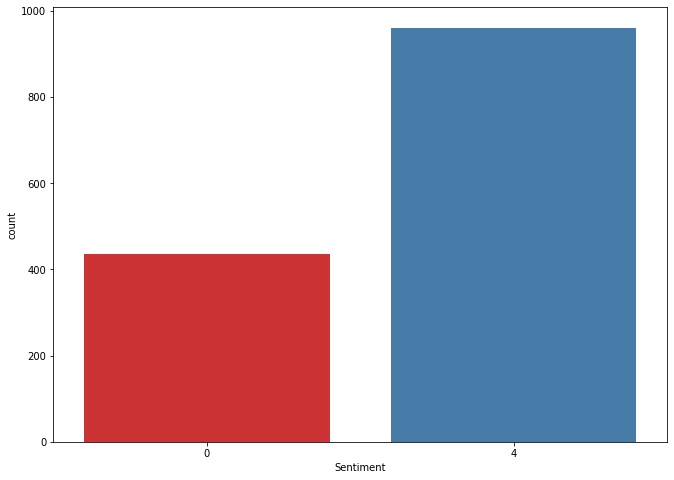

In [79]:
# checking dataset of NUS
import seaborn as sns
nus_sent.groupby("Sentiment").count()
#traindata[["cardio","height"]].groupby("Outcome").count()
sns.countplot(x="Sentiment", data=nus_sent, palette="Set1")
print ('NUS Tweets Sentiment')

print(colored("NUS Sentiment distribution:", "blue"))
print(nus_sent['Sentiment'].value_counts())

SMU Tweets Sentiment
SMU Sentiment distribution:
4    940
0    560
Name: Sentiment, dtype: int64


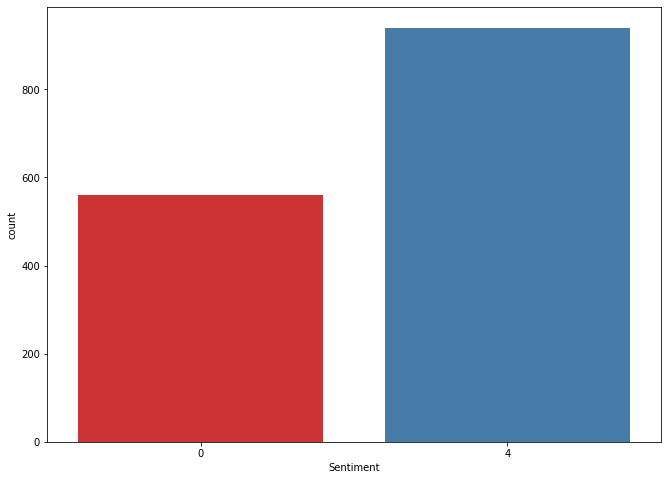

In [80]:
# checking dataset of SMU
import seaborn as sns
smu_sent.groupby("Sentiment").count()
sns.countplot(x="Sentiment", data=smu_sent, palette="Set1")
print ('SMU Tweets Sentiment')

print(colored("SMU Sentiment distribution:", "grey"))
print(smu_sent['Sentiment'].value_counts())

In [ ]:
#dftest.date = pd.to_datetime(dftest.date).dt.to_period('y')
#dftest.head(2)
ntu_sent.Date = pd.to_datetime(ntu_sent.Date).dt.to_period('m')
ntu_sent.Date.head(10)

In [75]:
ntu_sent.Date.tail(10)

1188    2020-02
1189    2020-02
1190    2020-02
1191    2020-02
1192    2020-02
1193    2020-02
1194    2020-02
1195    2020-02
1196    2020-02
1197    2020-02
Name: Date, dtype: period[M]

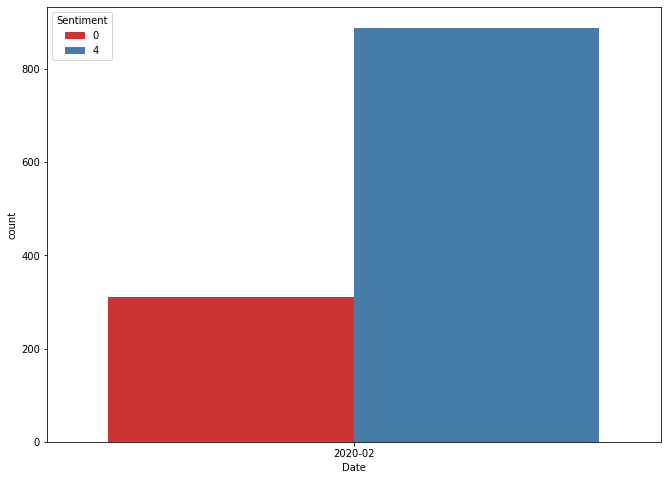

In [72]:
# Explore at what sentiment by date
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
sns.countplot(x='Date', hue='Sentiment', data = ntu_sent, palette="Set1");

Visualize NTU sentiment with date


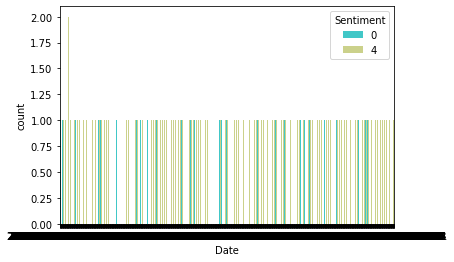

In [55]:
# visualize cardio with gender
sns.countplot(x='Date',data=ntu_sent,hue='Sentiment',palette='rainbow')
print ('Visualize NTU sentiment with date')

# LSTM

In [ ]:
# Load data
print(colored("Loading train and test data", "yellow"))
train_data = pd.read_csv('C:/Users/Phu Wai Paing/Desktop/Course Books/Text and Web Mining/TrainTestSplitCSV/train.csv')
test_data = pd.read_csv('C:/Users/Phu Wai Paing/Desktop/Course Books/Text and Web Mining/TrainTestSplitCSV/test.csv')
print(colored("Data loaded", "yellow"))

# Tokenization
print(colored("Tokenizing and padding data", "yellow"))
tokenizer = Tokenizer(num_words = 2000, split = ' ')
tokenizer.fit_on_texts(train_data['Tweet'].astype(str).values)
train_tweets = tokenizer.texts_to_sequences(train_data['Tweet'].astype(str).values)
max_len = max([len(i) for i in train_tweets])
train_tweets = pad_sequences(train_tweets, maxlen = max_len)
test_tweets = tokenizer.texts_to_sequences(test_data['Tweet'].astype(str).values)
test_tweets = pad_sequences(test_tweets, maxlen = max_len)
print(colored("Tokenizing and padding complete", "yellow"))

# Building the model
print(colored("Creating the LSTM model", "yellow"))
model = Sequential()
model.add(Embedding(2000, 128, input_length = train_tweets.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

# Training the model
print(colored("Training the LSTM model", "green"))
history = model.fit(train_tweets, pd.get_dummies(train_data['Sentiment']).values, epochs = 1, batch_size = 128, validation_split = 0.2)
print(colored(history, "green"))

# Testing the model
print(colored("Testing the LSTM model", "green"))
score, accuracy = model.evaluate(test_tweets, pd.get_dummies(test_data['Sentiment']).values, batch_size = 128)
print("Test accuracy: {}".format(accuracy))